In [12]:
import pandas as pd

In [13]:
ticket_data = pd.read_csv('../../../../working/metrics/ticketing/orders.csv', parse_dates=['created_at', 'event_date'])

In [14]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3293 entries, 0 to 3292
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   object                  3293 non-null   object        
 1   id                      3293 non-null   object        
 2   postcode_from_question  3123 non-null   object        
 3   postcode_from_address   34 non-null     object        
 4   created_at              3293 non-null   datetime64[ns]
 5   event_id                3293 non-null   object        
 6   event_name              3293 non-null   object        
 7   event_date              3293 non-null   datetime64[ns]
 8   number_of_tickets       3293 non-null   int64         
 9   referral_tag            0 non-null      float64       
 10  status                  3293 non-null   object        
 11  status_message          51 non-null     object        
dtypes: datetime64[ns](2), float64(1), int64(1), obje

In [15]:
completed_orders = ticket_data.loc[~ticket_data.status.isin(['cancelled']), ticket_data.columns]

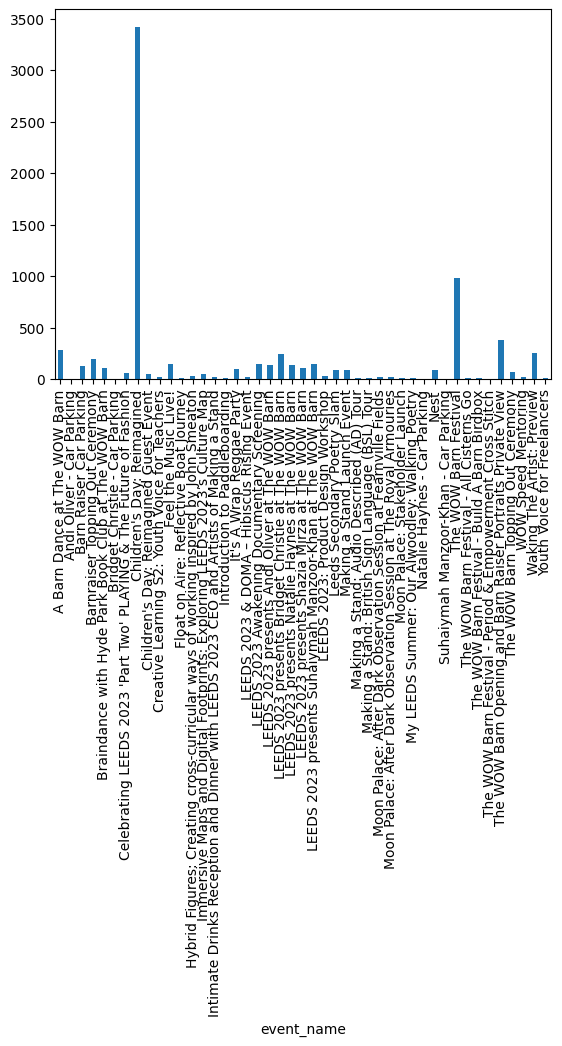

In [19]:
chart = completed_orders.groupby(['event_name']).number_of_tickets.sum().plot.bar()

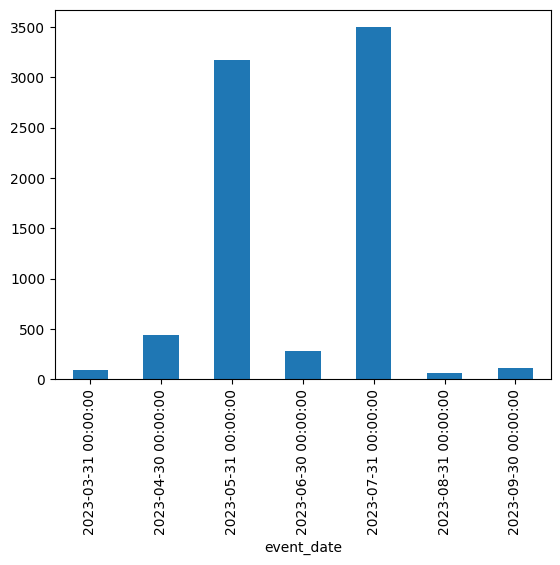

In [16]:
chart = completed_orders.groupby(['event_date']).number_of_tickets.sum().resample('M').sum().plot.bar()
